<a href="https://colab.research.google.com/github/ronthalanki/proj4/blob/main/proj4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [2]:
!pip install xmltodict

In [3]:
import glob
import os
import re
import random
from tqdm import tqdm
import uuid
import xmltodict

import numpy as np
import pandas as pd
import cv2
from skimage import io, transform
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

# DataLoader

Loading the dataset



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
root_file_path = "/content/drive/My Drive/Colab Notebooks"
dataset_file_path = "/content/ibug_300W_large_face_landmark_dataset"
metadata_file_name = "/labels_ibug_300W_train.xml"
torch_metadata_file_name = "/part3_metadata.csv"

In [7]:
dataset_files = sorted(glob.glob(dataset_file_path + "/*"))
print(dataset_files)

['/content/ibug_300W_large_face_landmark_dataset/afw', '/content/ibug_300W_large_face_landmark_dataset/helen', '/content/ibug_300W_large_face_landmark_dataset/ibug', '/content/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml', '/content/ibug_300W_large_face_landmark_dataset/lfpw']


Create a .csv file with all annotations

In [8]:
f = open(dataset_file_path + metadata_file_name,'r')
xml = xmltodict.parse(f.read())

In [9]:
with open(root_file_path + "/" + torch_metadata_file_name, "w") as torch_metadata:
  for image_idx in range(len(xml["dataset"]["images"]["image"])):
    f = xml["dataset"]["images"]["image"][image_idx]
    file_name = f["@file"]

    box_top = f["box"]["@top"]
    box_left  = f["box"]["@left"]
    box_width = f["box"]["@width"]
    box_height = f["box"]["@height"]

    keypts = []
    for keypoint_idx in range(len(f["box"]["part"])):
      keypts.append(f["box"]["part"][keypoint_idx]["@x"])
      keypts.append(f["box"]["part"][keypoint_idx]["@y"])
    
    row = file_name + "," + box_top + "," + box_left + "," + box_width + "," + box_height + "," + \
      ",".join([str(x) for x in keypts]) + "\n"

    torch_metadata.write(row)
# the nose keypoint
# nose_keypoint = np.array(landmark).astype('float32') # [-6]

In [10]:
df = pd.read_csv(root_file_path + "/" + torch_metadata_file_name, header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,lfpw/trainset/image_0457.png,78,74,138,140,55,141,59,161,66,182,75,197,90,209,108,220,131,226,149,232,167,230,181,225,184,208,186,193,185,179,184,167,186,152,185,142,181,133,95,...,139,194,151,186,159,180,163,182,168,180,173,183,176,189,174,193,170,197,165,199,160,199,152,198,143,194,159,186,163,187,168,186,174,189,168,191,164,192,160,192
1,helen/trainset/2659264056_1.jpg,130,31,447,447,107,150,99,238,97,314,98,375,107,439,133,493,161,541,180,571,216,592,254,600,319,592,385,574,446,544,494,497,526,431,554,365,575,308,111,...,168,468,190,462,210,456,233,471,262,472,287,493,314,511,280,523,251,525,225,515,195,505,180,490,179,470,205,473,230,486,258,490,304,503,258,490,230,486,205,473
2,helen/trainset/249852286_2.jpg,378,279,446,447,260,492,269,564,276,634,282,701,301,765,344,818,398,861,464,891,539,895,601,875,647,827,677,776,693,726,700,672,712,630,715,576,717,513,330,...,430,736,474,730,506,728,532,735,557,728,584,730,607,733,583,762,557,773,532,777,507,775,470,767,444,739,507,746,532,747,557,745,596,736,557,745,532,747,507,746
3,afw/281972218_1.jpg,247,878,259,259,925,341,925,369,926,399,933,431,948,466,964,497,980,526,999,548,1037,552,1079,546,1119,529,1153,505,1180,476,1198,433,1199,389,1195,348,1190,299,915,...,962,475,959,460,968,451,976,454,986,450,1002,463,1025,474,1002,488,990,489,981,490,973,488,967,485,967,474,972,473,980,473,988,472,1012,473,988,472,980,473,972,473
4,helen/trainset/2948551782_1.jpg,693,940,1110,1111,1060,1025,1081,1180,1121,1315,1160,1443,1228,1567,1302,1664,1393,1758,1498,1823,1611,1838,1730,1795,1834,1701,1920,1588,1982,1477,2024,1354,2054,1209,2067,1092,2055,963,1103,...,1407,1500,1470,1465,1539,1443,1574,1456,1612,1439,1682,1445,1746,1479,1693,1554,1627,1601,1583,1605,1542,1603,1468,1574,1432,1505,1531,1506,1581,1499,1624,1501,1720,1481,1624,1501,1581,1510,1531,1506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6661,helen/trainset/2620748776_1_mirror.jpg,40,405,600,590,368,179,362,267,363,369,375,458,401,559,438,637,497,702,573,733,661,737,734,718,781,663,812,593,845,518,874,453,896,385,892,320,890,255,471,...,545,471,606,469,661,471,683,478,708,474,752,481,785,500,745,563,703,581,678,581,651,576,601,555,560,475,661,484,683,486,706,487,769,502,706,551,679,553,655,550
6662,helen/trainset/2609109576_1_mirror.jpg,195,170,343,336,152,310,150,350,153,389,158,429,166,473,192,508,233,528,277,543,318,549,363,551,404,542,430,525,451,496,461,462,466,425,468,389,468,351,194,...,264,438,298,424,321,419,336,428,350,424,368,434,389,457,367,459,347,459,332,457,317,454,295,450,276,438,319,437,335,438,350,441,381,454,350,441,335,438,319,437
6663,lfpw/testset/image_0234_mirror.jpg,93,83,151,151,97,142,98,158,102,174,104,192,111,208,122,222,135,234,150,245,168,246,186,239,197,227,207,214,215,200,218,184,220,168,223,151,224,135,105,...,137,204,148,203,157,201,164,202,172,200,181,201,190,202,183,211,173,217,165,218,156,218,147,216,142,205,157,206,164,206,172,205,187,203,172,207,165,209,157,208
6664,helen/trainset/2615918865_1_mirror.jpg,240,822,1332,1333,1075,732,1050,840,1047,957,1073,1050,1127,1148,1179,1265,1220,1389,1273,1496,1383,1564,1521,1577,1664,1517,1811,1431,1954,1311,2021,1187,2060,1056,2100,906,2112,752,1064,...,1213,1171,1259,1211,1320,1236,1388,1269,1462,1263,1586,1258,1713,1252,1587,1335,1464,1368,1390,1364,1320,1331,1263,1275,1226,1195,1318,1260,1388,1292,1463,1292,1681,1257,1463,1292,1388,1292,1318,1260


In [11]:
 class FaceDataset(Dataset):
  def __init__(self, csv_file, root_dir, train, transform=None):
    if train:
      self.landmarks_frame = pd.read_csv(csv_file, header=None).head(6000)
    else:
      self.landmarks_frame = pd.read_csv(csv_file, header=None).tail(666)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.landmarks_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
    image = io.imread(img_name)
    bounding_box = np.array(self.landmarks_frame.iloc[idx, 1:5]).astype('int')
    for i in range(len(bounding_box)):
      if bounding_box[i] < 0:
        bounding_box[i] = 0
    landmarks = np.array(self.landmarks_frame.iloc[idx, 5:]).astype('float')
    #landmarks = landmarks.astype('float').flatten()
    sample = {'image': image, 'box': bounding_box, 'landmarks': landmarks.reshape((68,2))}

    if self.transform:
      sample = self.transform(sample)

    return sample


In [12]:
class GrayscaleNormalized(object):
  def __call__(self, sample):
    image = sample['image']

    colorJitter = transforms.Compose([transforms.ColorJitter(brightness=0.5, contrast=0.5)])
    image = np.array(colorJitter(Image.fromarray(image)))

    return {
      'image': rgb2gray(image),
      'box': sample['box'],
      'landmarks': sample['landmarks']
    }

In [13]:
class Rescale(object):
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image = sample['image']
    image = image[sample['box'][0]: sample['box'][0] + sample['box'][3], sample['box'][1]: sample['box'][1] + sample['box'][2]]
    image = transform.resize(image, (224,224)) 
    
    landmarks = sample["landmarks"]
    landmarks = 1.0 * (landmarks - np.array(sample["box"][1], sample["box"][0])) / np.array([sample['box'][2], sample['box'][3]])
    return {'image': image, 'box': sample['box'], 'landmarks': landmarks}

In [14]:
def rigid_transform_about_origin(img, landmarks, shift, rotation):
  rotated = ndimage.rotate(img, rotation, reshape=False)
    
  landmarks = landmarks - np.array([0.5,0.5])

  a = np.deg2rad(rotation)
  new = np.zeros((68,2))
  new[:,0] = landmarks[:,0]*np.cos(a) + landmarks[:,1]*np.sin(a)
  new[:,1] = -landmarks[:,0]*np.sin(a) + landmarks[:,1]*np.cos(a)

  #new = new + np.array([0.5,0.5])
  shifted = ndimage.shift(rotated, (shift[0], shift[1]))
  landmarks[:,1] = new[:,1] + shift[0] / 224
  landmarks[:,0] = new[:,0] + shift[1] / 224

  return shifted, landmarks

In [15]:
class Random(object):
  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']
    landmarks = landmarks.reshape((68,2))

    rotate_angle = random.randint(-15,15)
    shift_x = random.randint(-10,10)
    shift_y = random.randint(-10,10)

    image, landmarks = rigid_transform_about_origin(image, landmarks, (shift_x, shift_y), rotate_angle)

    return {'image': image, 'box': sample['box'], 'landmarks': landmarks}

In [16]:
class NpTensor(object):
  def __call__(self, sample):
    image = sample['image']
    return {'image': torch.from_numpy(np.expand_dims(image, -1).transpose((2,0,1))), 'box': sample['box'], 'landmarks': sample['landmarks'].flatten()}

In [17]:
composed = transforms.Compose([GrayscaleNormalized(), Rescale((224, 224)), NpTensor()])

train_face_dataset = FaceDataset(
  csv_file= root_file_path + "/" + torch_metadata_file_name,
  root_dir= dataset_file_path,
  train=True,
  transform=composed
)

test_face_dataset = FaceDataset(
  csv_file= root_file_path + "/" + torch_metadata_file_name,
  root_dir= dataset_file_path,
  train=False,
  transform=composed
)

In [18]:
train_dataloader = DataLoader(train_face_dataset, batch_size=16, shuffle=True) #16 for batch size
test_dataloader = DataLoader(test_face_dataset, batch_size=1, shuffle=True) #batch size is size of dataset for speed

In [19]:
class Net(nn.Module):
  def __init__(self, pretrained_model):
    super(Net,self).__init__()
    self.pretrained_model = pretrained_model
    self.conv1 = nn.Conv2d(1, 3, 1).cuda()
    self.base = nn.Sequential(*list(pretrained_model.children())[:-1]).cuda()
    self.fc1 = nn.Linear(512, 68*2).cuda()

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.base(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    return x.to(device) 

In [ ]:
model = models.resnet18(pretrained=True)
net = Net(model).cuda()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [21]:
training_losses = []
test_losses = []

with torch.no_grad():
  for epoch in tqdm(range(5)):
    curr_loss = 0.0
    count = 0
    for i, sample in enumerate(train_dataloader):
      input = sample["image"].to(device)
      output = net(input).to(device)
      target = sample["landmarks"].to(device)
      loss = criterion(output, target)
      optimizer.zero_grad()
      loss.backward()
      x = loss.item()
      curr_loss += x
      count += 1
      optimizer.step()
      break

    training_losses.append(curr_loss / count)

    test_loss = 0.0
    for i, sample in enumerate(test_dataloader):
      input = sample["image"].to(device)
      output = net(input).to(device)
      target = sample["landmarks"].to(device)
      loss = criterion(output, target)
      test_loss += loss.item()
      break
    test_losses.append(test_loss / len(test_dataloader))

100%|██████████| 5/5 [00:20<00:00,  4.20s/it]


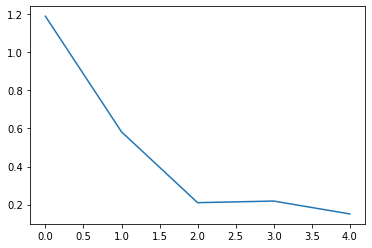

In [22]:
plt.plot(training_losses)
plt.savefig(root_file_path + "/part3_training_loss.jpg")
plt.show()

In [23]:
plt.savefig(root_file_path + "/part3_test_loss.jpg")
plt.show()

<Figure size 432x288 with 0 Axes>

In [24]:
def display_image(sample, output):
  image = sample["image"].cpu()[0][0].detach().numpy() # + 0.5
  actual_keypoint = sample["landmarks"].cpu()[0].detach().numpy().reshape((68,2))
  predicted_keypoint = output.detach().numpy().reshape((68,2))
  print(actual_keypoint)
  #actual_keypoint += np.array([0.5, 0.5])
  #predicted_keypoint += np.array([0.5, 0.5])

  r_output = 224 * predicted_keypoint[:, 0]
  c_output = 224 * predicted_keypoint[:, 1]

  r_actual = 224 * actual_keypoint[:, 0]
  c_actual = 224 * actual_keypoint[:, 1]

  plt.imshow(image, cmap="gray")
  plt.scatter([r_actual],[c_actual],color='r')
  plt.scatter([r_output],[c_output],color='b')
  # plt.savefig(root_file_path + "/part2_" + str(uuid.uuid4()) + ".jpg")

[[ 0.15555556 -0.12777778]
 [ 0.13888889 -0.01666667]
 [ 0.13333333  0.08888889]
 [ 0.14444444  0.20555556]
 [ 0.18333333  0.33333333]
 [ 0.23888889  0.44444444]
 [ 0.32222222  0.54444444]
 [ 0.41111111  0.62777778]
 [ 0.52222222  0.66111111]
 [ 0.65555556  0.63888889]
 [ 0.78333333  0.56111111]
 [ 0.89444444  0.47777778]
 [ 0.98333333  0.36666667]
 [ 1.04444444  0.23333333]
 [ 1.08888889  0.1       ]
 [ 1.11666667 -0.04444444]
 [ 1.12222222 -0.18333333]
 [ 0.17222222 -0.29444444]
 [ 0.21666667 -0.32222222]
 [ 0.27222222 -0.31111111]
 [ 0.33888889 -0.29444444]
 [ 0.4        -0.26111111]
 [ 0.61666667 -0.26111111]
 [ 0.69444444 -0.3       ]
 [ 0.78888889 -0.32222222]
 [ 0.87222222 -0.30555556]
 [ 0.93888889 -0.24444444]
 [ 0.48888889 -0.16111111]
 [ 0.48333333 -0.08333333]
 [ 0.46666667  0.00555556]
 [ 0.45555556  0.08888889]
 [ 0.41666667  0.15555556]
 [ 0.44444444  0.17222222]
 [ 0.47222222  0.18333333]
 [ 0.52222222  0.16666667]
 [ 0.57222222  0.16111111]
 [ 0.24444444 -0.16111111]
 

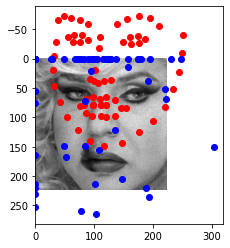

In [25]:
test_loss = 0.0
for i, sample in enumerate(test_dataloader):
  input = sample["image"].to(device)
  output = net(input).to(device)
  target = sample["landmarks"].to(device)
  loss = criterion(output, target)
  #print(output)
  #print(target)
  test_loss += loss.item()
  display_image(sample, output.cpu())
  break
test_loss = test_loss / len(test_dataloader)

print(test_loss)

In [68]:
# torch.save(net, root_file_path + "/nose_cnn")

In [ ]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()
    
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  #layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  
  #getting the weight tensor data
  weight_tensor =  list(model.children())[layer_num] .weight.data
  if single_channel:
    if collated:
      plot_filters_single_channel_big(weight_tensor)
    else:
      plot_filters_single_channel(weight_tensor)
      
  else:
    if weight_tensor.shape[1] == 3:
      plot_filters_multi_channel(weight_tensor)
    else:
      print("Can only plot weights with three channels with single channel = False")

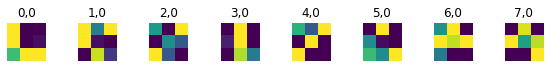

In [ ]:
plot_weights(net, 0)